In [ ]:
# !wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg

In [ ]:
from rfdetr import RFDETRMedium

model = RFDETRMedium()

In [ ]:
# model.train(dataset_dir='coco/', epochs=100, batch_size=2, grad_accum_steps=2, resume='output/checkpoint.pth')
model.train(dataset_dir='coco/', epochs=100, batch_size=2, grad_accum_steps=2)

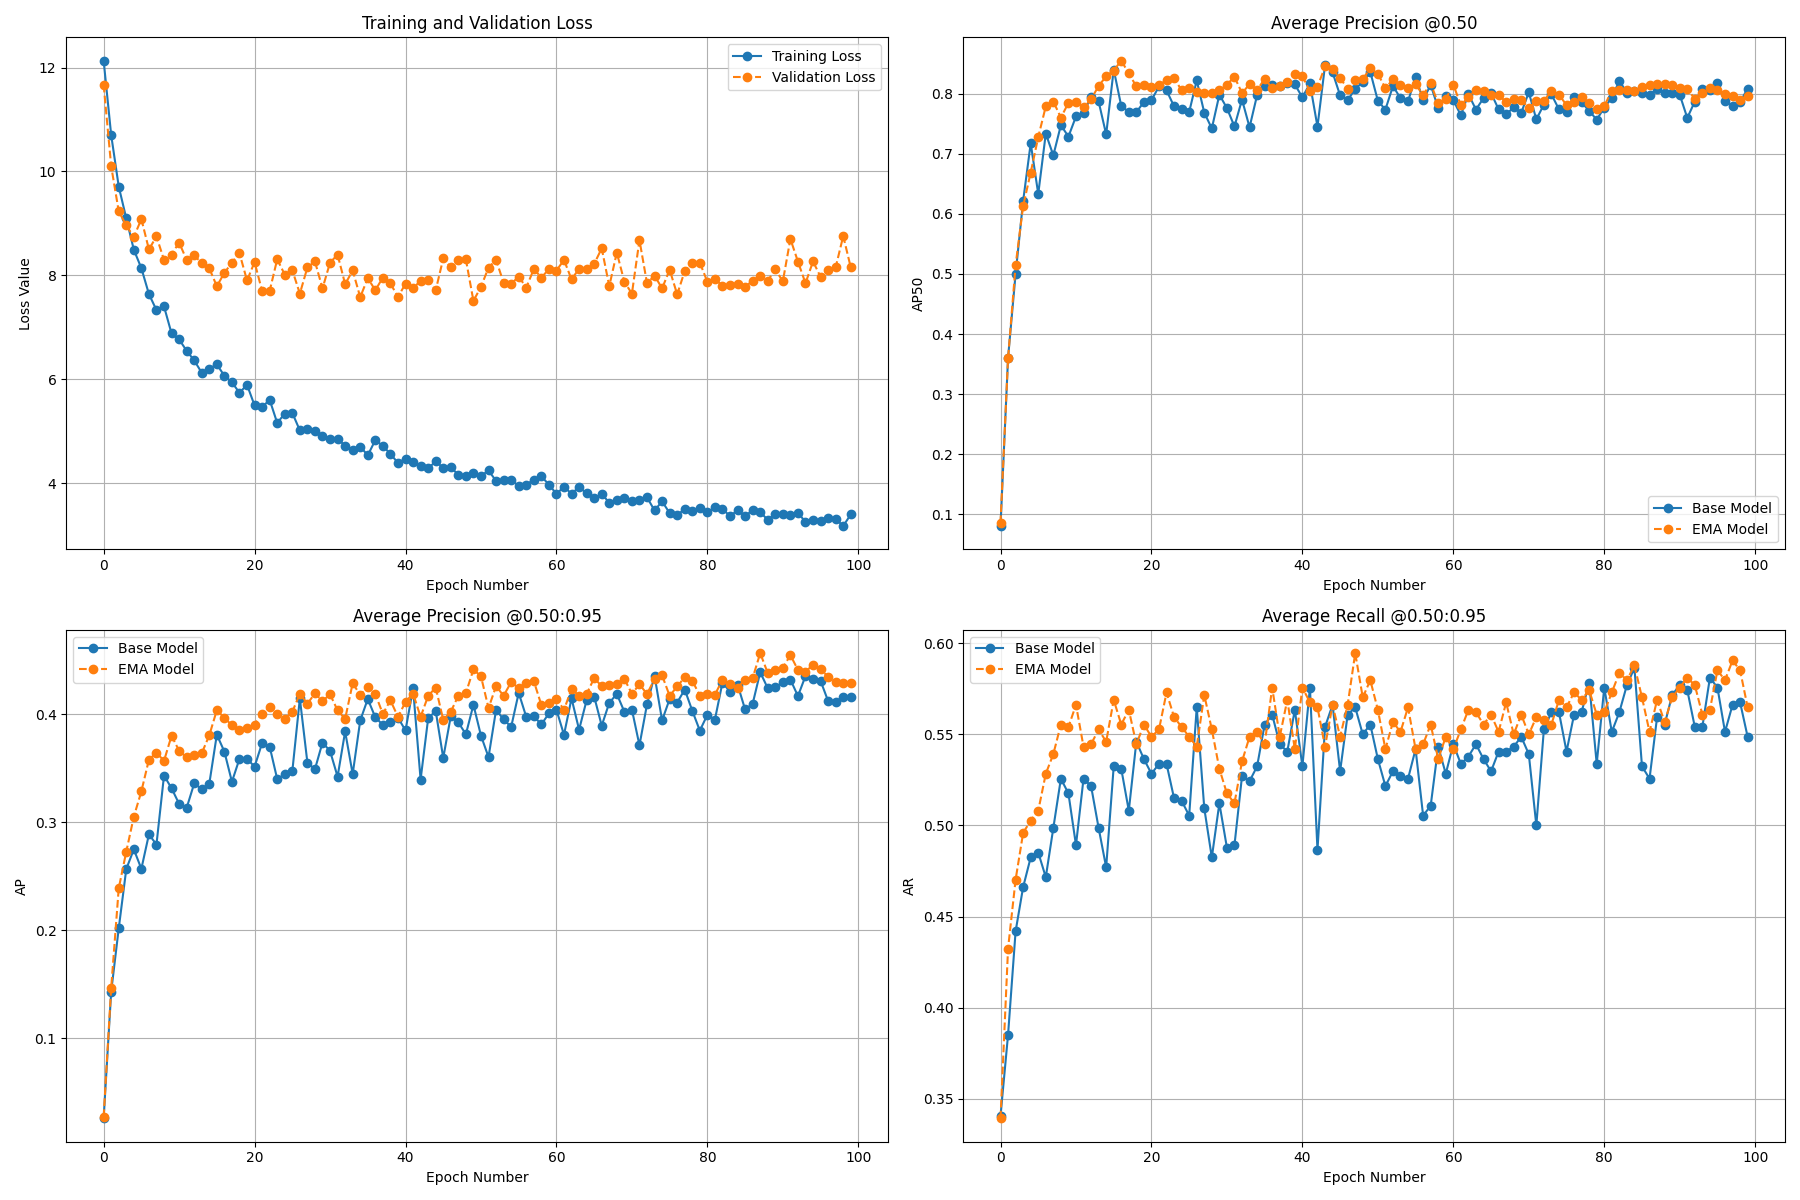

In [2]:
from PIL import Image

Image.open("output/metrics_plot.png")

In [ ]:

# model.deploy_to_roboflow(
#   workspace="roboflow-jvuqo",
#   project_id="basketball-player-detection-2",
#   version=13,
#   api_key=os.environ["ROBOFLOW_API_KEY"]
# )


In [ ]:
import gc
import torch
import weakref

def cleanup_gpu_memory(obj=None, verbose: bool = False):

    if not torch.cuda.is_available():
        if verbose:
            print("[INFO] CUDA is not available. No GPU cleanup needed.")
        return

    def get_memory_stats():
        allocated = torch.cuda.memory_allocated()
        reserved = torch.cuda.memory_reserved()
        return allocated, reserved

    torch.cuda.synchronize()

    if verbose:
        alloc, reserv = get_memory_stats()
        print(f"[Before] Allocated: {alloc / 1024**2:.2f} MB | Reserved: {reserv / 1024**2:.2f} MB")

    # Ensure we drop all strong references
    if obj is not None:
        ref = weakref.ref(obj)
        del obj
        if ref() is not None and verbose:
            print("[WARNING] Object not fully garbage collected yet.")

    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

    torch.cuda.synchronize()

    if verbose:
        alloc, reserv = get_memory_stats()
        print(f"[After]  Allocated: {alloc / 1024**2:.2f} MB | Reserved: {reserv / 1024**2:.2f} MB")
     

In [ ]:
model = RFDETRMedium(pretrain_weights="output/checkpoint_best_total.pth")
model.optimize_for_inference()

In [ ]:
import supervision as sv

ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"coco/test",
    annotations_path=f"coco/test/_annotations.coco.json",
)


In [ ]:
import supervision as sv
from tqdm import tqdm
from supervision.metrics import MeanAveragePrecision

targets = []
predictions = []

for path, image, annotations in tqdm(ds):
    image = Image.open(path)
    detections = model.predict(image, threshold=0)

    targets.append(annotations)
    predictions.append(detections)

In [ ]:
map_metric = MeanAveragePrecision()
map_result = map_metric.update(predictions, targets).compute()
print(map_result)

In [ ]:
Average Precision (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.444
Average Precision (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.848
Average Precision (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.378
Average Precision (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.386
Average Precision (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]                 = 0.435
Average Precision (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ]                 = 0.546

In [ ]:
Average Precision (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.457
Average Precision (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.895
Average Precision (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.397
Average Precision (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.027
Average Precision (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]                 = 0.476
Average Precision (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ]                 = 0.604

In [ ]:
Average Precision (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.378
Average Precision (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.738
Average Precision (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.350
Average Precision (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.016
Average Precision (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]                 = 0.405
Average Precision (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ]                 = 0.492

In [ ]:
Average Precision (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.344
Average Precision (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.772
Average Precision (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.285
Average Precision (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.008
Average Precision (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]                 = 0.358
Average Precision (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ]                 = 0.485

In [ ]:
from rfdetr import RFDETRBase
import supervision as sv
from PIL import Image
import random

i = random.randint(0, len(ds) - 1)

path, image, annotations = ds[i]
image = Image.open(path)

detections = model.predict(image, threshold=0.5)

text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)
color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff66ff", "#3399ff", "#ff66b2", "#ff8080",
    "#b266ff", "#9999ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])

bbox_annotator = sv.BoxAnnotator(color=color,thickness=thickness)
label_annotator = sv.LabelAnnotator(
    color=color,
    text_color=sv.Color.BLACK,
    text_scale=text_scale)

annotations_labels = [
    f"{ds.classes[class_id]}"
    for class_id
    in annotations.class_id
]

detections_labels = [
    f"{ds.classes[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotation_image = image.copy()
annotation_image = bbox_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

detections_image = image.copy()
detections_image = bbox_annotator.annotate(detections_image, detections)
detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

sv.plot_images_grid(images=[annotation_image, detections_image], grid_size=(1, 2), titles=["Annotation", "Detection"])
     

In [ ]:
import numpy as np
import supervision as sv
from PIL import Image
import os
from rfdetr import RFDETRMedium

In [ ]:
model = RFDETRMedium(pretrain_weights="output/checkpoint_best_total.pth")
model.optimize_for_inference()

In [ ]:
file1 = '/home/ai-17/Downloads/H/HA1040-4_phase_split/blastocyst'
images = os.listdir(file1)

for i in images:

    image = Image.open(f"{file1}/{i}").convert("RGB")

    detections = model.predict(image, threshold=0.5)

    color = sv.ColorPalette.from_hex([
        "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
        "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
    ])
    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
    thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

    bbox_annotator = sv.BoxAnnotator(color=color, thickness=thickness)
    label_annotator = sv.LabelAnnotator(
        color=color,
        text_color=sv.Color.BLACK,
        text_scale=text_scale,
        smart_position=True
    )

    labels = [
        f"CS {confidence:.2f}"
        for class_id, confidence
        in zip(detections.class_id, detections.confidence)
    ]

    annotated_image = image.copy()
    annotated_image = bbox_annotator.annotate(annotated_image, detections)
    annotated_image = label_annotator.annotate(annotated_image, detections, labels)
    annotated_image.thumbnail((800, 800))
    annotated_image

    break

In [ ]:
annotated_image

In [7]:
import os
from PIL import Image
import supervision as sv  # assuming you're using Supervision

files = os.listdir('/home/ai-17/Downloads/H/')

files.remove("HA1040-4_phase_split")

for f in files:

    file1 = f'/home/ai-17/Downloads/H/{f}/blastocyst'

    # ✅ Create output folder with same name
    output_dir = f"{file1}_annotated"
    os.makedirs(output_dir, exist_ok=True)

    images = os.listdir(file1)

    for i in images:
        output_path = os.path.join(output_dir, i)
        if os.path.exists(output_path):
            continue

        image_path = os.path.join(file1, i)
        try:
            image = Image.open(image_path).convert("RGB")
        except:
            continue

        detections = model.predict(image, threshold=0.5)

        color = sv.ColorPalette.from_hex([
            "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
            "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
        ])
        text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
        thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

        bbox_annotator = sv.BoxAnnotator(color=color, thickness=thickness)
        label_annotator = sv.LabelAnnotator(
            color=color,
            text_color=sv.Color.BLACK,
            text_scale=text_scale,
            smart_position=True
        )

        labels = [
            f"CS {confidence:.2f}"
            for class_id, confidence
            in zip(detections.class_id, detections.confidence)
        ]

        annotated_image = image.copy()
        annotated_image = bbox_annotator.annotate(annotated_image, detections)
        annotated_image = label_annotator.annotate(annotated_image, detections, labels)
        annotated_image.thumbnail((800, 800))

        # ✅ Save image with same filename in output folder
        annotated_image.save(output_path)

        print(f"Saved: {output_path}")


Saved: /home/ai-17/Downloads/H/IZ1001-1_phase_split/blastocyst_annotated/438.jpeg
Saved: /home/ai-17/Downloads/H/IZ1001-1_phase_split/blastocyst_annotated/435.jpeg
Saved: /home/ai-17/Downloads/H/IZ1001-1_phase_split/blastocyst_annotated/410.jpeg
Saved: /home/ai-17/Downloads/H/IZ1001-1_phase_split/blastocyst_annotated/427.jpeg
Saved: /home/ai-17/Downloads/H/IZ1001-1_phase_split/blastocyst_annotated/405.jpeg
Saved: /home/ai-17/Downloads/H/IZ1001-1_phase_split/blastocyst_annotated/384.jpeg
Saved: /home/ai-17/Downloads/H/HS893-8_phase_split/blastocyst_annotated/519.jpeg
Saved: /home/ai-17/Downloads/H/HS893-8_phase_split/blastocyst_annotated/551.jpeg
Saved: /home/ai-17/Downloads/H/HS893-8_phase_split/blastocyst_annotated/504.jpeg
Saved: /home/ai-17/Downloads/H/HS893-8_phase_split/blastocyst_annotated/558.jpeg
Saved: /home/ai-17/Downloads/H/HS893-8_phase_split/blastocyst_annotated/440.jpeg
Saved: /home/ai-17/Downloads/H/HS893-8_phase_split/blastocyst_annotated/559.jpeg
Saved: /home/ai-17/Dow